In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
import helpers
from helpers import *
import pickle
from matplotlib.pyplot import figure
%matplotlib inline
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
%pwd

'/Users/thomasspringett/github/heartrate'

In [3]:
csv_file = 'data/HeartRateData.csv'
df_raw = pd.read_csv(csv_file)
df_raw=df_raw.drop('DateTime',1)
df_raw.head(3)

,BPM
0,77
1,69
2,69


In [4]:
print (round(df_raw.BPM.describe()))

count    349768.0
mean         78.0
std          24.0
min          30.0
25%          61.0
50%          69.0
75%          86.0
max         215.0
Name: BPM, dtype: float64


In [5]:
def zones(df_raw, age):
    max_hr = 220 - age
    target_low = 0.64*max_hr
    target_high = 0.76*max_hr
    target_intensity_lo = 0.76*max_hr
    target_intensity_hi = 0.93*max_hr
    print ("For Age: {} Maximum HR: {}".format(age,max_hr))
    print ("Target HR Lower Bound:", target_low)
    print ("Target HR Upper Bound:", target_high)
    print ("Target HR Intensity Upper Bound:", target_intensity_hi)
    return max_hr, target_low, target_high, target_intensity_lo, target_intensity_hi

In [6]:
max_hr, target_low, target_high, target_intensity_lo, target_intensity_hi = zones(df_raw,62)

For Age: 62 Maximum HR: 158
Target HR Lower Bound: 101.12
Target HR Upper Bound: 120.08
Target HR Intensity Upper Bound: 146.94


In [7]:
def plot_data_histo(totals): 
    #Histogram of the number of missing values per column (featrure).
    xref = [max_hr,target_low, target_high,target_intensity_hi]
    ref_colors=['r','g','y','b']

    for ref, c in zip(xref,ref_colors):
        plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
    plt.legend()
    plt.grid(True)
    plt.xlabel('Beats/Minute')
    plt.ylabel('Count')
    plt.title('Heart Rate Distribution')
    plt.hist(df_raw.BPM,50)
    plt.show()

In [8]:
def hr_zone_histogram(df): 
    
    if  'Label' in df: 
        df.drop("Label",axis='columns',inplace=True)
    kmeans = KMeans(n_clusters=5)
    model = kmeans.fit(df)
    centers = np.round(model.cluster_centers_,0)
    print ("\nCluster {}: {}".format(k,centers))
    labels = kmeans.predict(df)
    print ("KMeans Labels: ",np.unique(labels))   
   
    df.insert(1,"Label",labels)

    clusterCounts(labels)
    #Histogram of the number of missing values per column (featrure).
    xref = [max_hr,target_low, target_high,target_intensity_hi]
    ref_colors=['r','g','y','b']

    #for ref, c in zip(xref,ref_colors):
    #    plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
        
    zone1 = df.loc[df.Label ==0, 'BPM']
    zone2 = df.loc[df.Label ==1, 'BPM']
    zone3 = df.loc[df.Label ==2, 'BPM']
    zone4 = df.loc[df.Label ==3, 'BPM']
    zone5 = df.loc[df.Label ==4, 'BPM']
    
    
    plt.figure(figsize=(10,5))
    # xticks = np.linspace(30, 200, 50)
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    

    
    #plt.grid(True)
    plt.title('Heart Rate Distribution')
    plt.hist(zone1, **kwargs, color='g', label='Zone 1')
    plt.hist(zone2, **kwargs, color='b', label='Zone 2')
    plt.hist(zone3, **kwargs, color='r', label='Zone 3')
    plt.hist(zone4, **kwargs, color='c', label='Zone 4')
    plt.hist(zone5, **kwargs, color='y', label='Zone 5')
    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    plt.xlim(30,200)
    plt.legend()
    plt.show()

In [9]:
#plot_data_histo1(df)

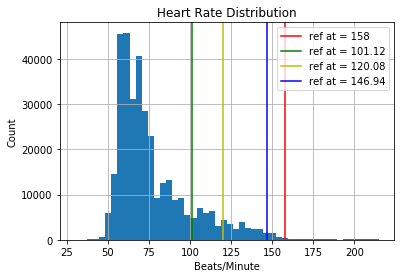

In [10]:
#print (df.BPM)
plot_data_histo(df_raw.BPM)

In [11]:
#df_raw.BPM.quantile([0.95,0.98,0.99])

In [12]:
hardware_limit = 210
df = df_raw[(df_raw.BPM < hardware_limit)]
num_screened = df_raw.shape[0]-df.shape[0]
print ("Applying hardware limit of {}bpm resulted in dropping {} data points.".format(hardware_limit,num_screened))

Applying hardware limit of 210bpm resulted in dropping 314 data points.


 Note that with KMeans clustering the data will not be split into training and test sets. Kmeans clustering is not a classification tool. The data is not labeled.

In [13]:

def scree_KMeans_plot(data,num_clusters):
    clusterCenters = [] 
    scores = [] 
    k_values = []
    start = timer()
    for k in range(1,num_clusters):
        k_values.append(k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(data)
        print ("\nCluster {}: {}".format(k,model.cluster_centers_))
        clusterCenters.append(model.cluster_centers_)
        labels = kmeans.predict(data)
        print ("Cluster Labels: ",np.unique(labels))
        score = -(kmeans.score(data))
        print ("score: ",round(score/100000000,2))
        scores.append(score)
    plt.plot(k_values, scores, marker = 'o')
    plt.ylabel('K-Cluster Score')
    plt.xlabel('k value')
    plt.title('Number of Clusters vs KMeans Score')
    plt.savefig('Cluster_vs_score_plot.png')
    plt.show()
    end = timer() 
    print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    return k_values, scores, labels


Cluster 1: [[77.52634109]]
Cluster Labels:  [0]
score:  1.89

Cluster 2: [[ 67.39849131]
 [115.66932624]]
Cluster Labels:  [0 1]
score:  0.54

Cluster 3: [[ 63.25309656]
 [127.76962689]
 [ 87.68667061]]
Cluster Labels:  [0 1 2]
score:  0.28

Cluster 4: [[ 80.2132846 ]
 [106.49140798]
 [ 61.97746584]
 [140.08461679]]
Cluster Labels:  [0 1 2 3]
score:  0.17

Cluster 5: [[ 88.02222863]
 [ 59.53639126]
 [142.22547081]
 [111.37086986]
 [ 71.5465335 ]]
Cluster Labels:  [0 1 2 3 4]
score:  0.12

Cluster 6: [[ 59.53639126]
 [108.33710588]
 [134.60010654]
 [180.75193399]
 [ 71.5465335 ]
 [ 87.37028392]]
Cluster Labels:  [0 1 2 3 4 5]
score:  0.09

Cluster 7: [[ 92.55217652]
 [ 57.91997182]
 [136.93746754]
 [ 77.89552437]
 [183.03125   ]
 [112.19663401]
 [ 67.00769094]]
Cluster Labels:  [0 1 2 3 4 5 6]
score:  0.06

Cluster 8: [[ 77.53533437]
 [126.24728659]
 [ 57.91997182]
 [ 90.89587328]
 [144.84094667]
 [ 67.00769094]
 [107.99964441]
 [187.34594223]]
Cluster Labels:  [0 1 2 3 4 5 6 7]
score:

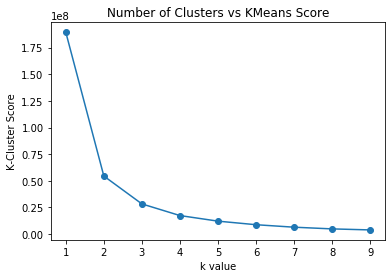


Function in 0.3 minutes


In [14]:

k_values, scores, labels = scree_KMeans_plot(df,10) 
k = zip(k_values, scores)
print (k)

In [15]:
if not 'Label' in df: 
    df.insert(1,"Label",labels)
df.tail(5)

,BPM,Label
349762,62,2
349763,67,8
349764,61,2
349765,63,8
349766,62,2


In [16]:
print ("KMeans Labels: ",np.unique(labels))     

KMeans Labels:  [0 1 2 3 4 5 6 7 8]


In [17]:
def clusterCounts(labels): 
    #Count number in each cluster for general population 
    clusterDict = collections.Counter(labels)
    clusterSum = sum(clusterDict.values())

    for key,value in sorted(clusterDict.items()): 
        print (key, ' ->',np.round(100*value/clusterSum),'%')

/Users/thomasspringett/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Cluster <zip object at 0x7fc857812a08>: [[ 71.]
 [113.]
 [144.]
 [ 88.]
 [ 59.]]
KMeans Labels:  [0 1 2 3 4]
0  -> 33.0 %
1  -> 11.0 %
2  -> 5.0 %
3  -> 16.0 %
4  -> 35.0 %


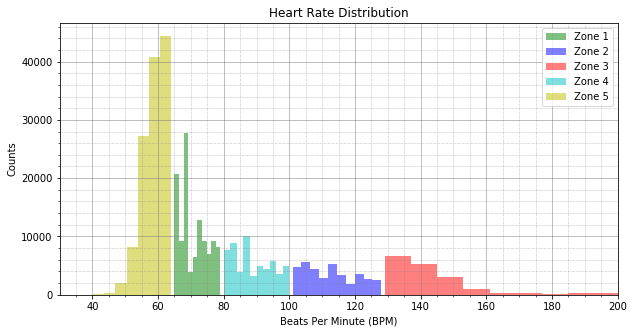

In [18]:
hr_zone_histogram(df)

In [19]:
def assignZone(value):
    zone = None
    if (value) < very_light: 
        zone = "zone1"
    elif (value > very_light) and (value < light):
        zone = "zone2"
    elif (value > light) and (value < moderate):
        zone = "zone3"
    elif (value > moderate) and (value < hard):
        zone = "zone4"    
    elif (value > hard) and (value < maximum):
        zone = "zone5"
        
    return zone

In [22]:
#x=df.BPM.quantile([0.5,0.6,0.7,0.8,0.9])
very_light = int(df.BPM.quantile([0.6]))
light = int(df.BPM.quantile([0.7]))
moderate = int(df.BPM.quantile([0.8]))
hard = int(df.BPM.quantile([0.9]))
maximum = int(df.BPM.quantile([1.0]))

df1=df.copy()
print ("Very Light: {} \nLight: {} \nModerate: {}\nHard: {} \nMaximum: {}".format(very_light,light,moderate,hard,maximum))
df1["Polar_Zone"] = df1.BPM.apply(assignZone)
df1.head()

Very Light: 74 
Light: 81 
Moderate: 92
Hard: 113 
Maximum: 209


,BPM,Label,Polar_Zone
0,77,0,zone2
1,69,0,zone1
2,69,0,zone1
3,69,0,zone1
4,69,0,zone1


In [23]:
#Checking for Zone assignment: 
df1.Polar_Zone.unique()

array(['zone2', 'zone1', 'zone3', 'zone4', None, 'zone5'], dtype=object)

In [ ]:
#for score in scores:
    #print (round(score/100000000,2))

def findK(df,limit): 
    for k in range(len(df)):
        if k == len(df):
           print ("end of array reached.")
            
        if k == 0: 
          improvement = 'None'
        if k > 0:
          improvement = (round(100*((df[k-1]-df[k])/df[k])))
          print (k,round(df[k]/100000000,2),improvement)
          if improvement < limit:
                break 
    print ("Less than {}% improvement in score after k = {}".format(limit,k))
findK(scores,10)      

In [ ]:
%%time
def silhouetteScore(df): 
    sil_scores = [] 
    start = timer()
    range_n_clusters = list(range(1,10))
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = kmeans.fit_predict(df)
        score = silhouette_score(df,cluster_labels)
        sil_scores.append(score)
        print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))
        end=timer()
        print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    print ("\nFinished!")
    return sil_scores

In [ ]:
#sil_scores = silhouetteScore(df)

In [ ]:
#pickle.dump(sil_scores,open('data/silhouetteScores','wb'))
silhouette = pickle.load(open('data/silhouetteScores', 'rb'))
print ("Sil Scores: ",silhouette)

In [ ]:
def silhouette_plot(scores, k_values):

    plt.ylabel('Silhouette Score')
    plt.xlabel('k value')
    plt.title('Silhouete For Best K')
    plt.ylim=(0.0,1.0)
    plt.grid(True)
    plt.plot(k_values, scores, marker = 'o')
    plt.show()

In [ ]:
print (len(k_values), len(silhouette))
oftype(k_values)
oftype(silhouette)
if len(k_values) > len(silhouette):
    k_values = k_values[:-1]
oftype(k_values)
print (len(k_values), len(silhouette))

In [ ]:
silhouette_plot(silhouette,k_values)

In [ ]:
def clusters_plot(df,num_clusters):
    
    if  'Label' in df: 
        df.drop("Label",axis='columns',inplace=True)
    kmeans = KMeans(n_clusters=num_clusters)
    model = kmeans.fit(df)
    print ("\nCluster {}: {}".format(k,model.cluster_centers_))
    labels = kmeans.predict(df)
    print ("KMeans Labels: ",np.unique(labels))   
   
    df.insert(1,"Label",labels)
 
    cluster0 = df.loc[df['Label'] == 0]
    cluster1 = df.loc[df['Label'] == 1]
    
    print ("cluster0.shape: ",cluster0.shape)
    print ("cluster1.shape: ",cluster1.shape)
    #print (cluster0.head())
    #print (cluster1.head())
    
    bins = np.linspace(30, 200, 50)
    plt.subplot(2,1,1)
    plt.hist(cluster0.BPM,bins)
    plt.title('Heart Rate Distribution for 2 Clusters')
  
    plt.grid(True)
    plt.ylabel('Cluster 0')
    
    plt.subplot(2,1,2)
    plt.hist(cluster1.BPM,bins) 
    plt.xlabel('Beats Per Minute')
    plt.ylabel('Cluster 1')
    plt.grid(True)
    plt.show()
        
clusters_plot(df,2)

The first step in determining high intensity heart rate zones is to determine maximum heart rate. There are several methods for this: 

1. 200 - 1/2 age. Or 168bpm for a 62 year old. 
2. 220 - age. 0r 158bpm for a 62 year old.
3. Heart Rate Monitor data collected over a period of months with various activities. 
4. Using a treadmill or stationary bike with an ECG. 

Option number 2 is the most common for folks that do not have access to the treadmill and ECG. It will be used for the remainder of the project. 

After the maximum heart rate is determined, target heart rates can be determined: 
1. Target active heart rate: 60-70%. Or 95 to 110 bpm for the 62 year old. 
2. Target Heart Rate is 64% to 76%. CDC. 
3. High Intensity target heart rate is 76-93% (CDC). Or 120 to 146 for the 62 year old. 
 
The heart rate monitor company Polar suggests 5 heart rate zones: 
1. Very light at 50-60% of HRMAX. Boost recovery and prepare for higher zones.
2. Light 60-70%. Improve general endurance and increase capillary density.
2. Moderate at 70-80%. Lactic acid build up,improve efficiency of blood circulation in the heart and muscles
4. Hard 80-90%. Improve speed endurance.
5. Maximum 90-100%. For elite atheletes to further improve speed. 